In [ ]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from loguru import logger

from src.cifar_autoencoder import CifarDataSet, AutoEncoder, train
from src.cifar_graph_classifier import Net
from torch.utils.data import DataLoader

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
logger.info(f"device -> {device}")

2021-01-19 22:24:33.724 | INFO     | __main__:<module>:1 - device -> cpu


In [7]:
train_ds = CifarDataSet(
            batch_dir_path="/home/pranjal/pytorch/Datasets/cifar-10-batches-py/", mode="train"
        )
test_ds = CifarDataSet(
            batch_dir_path="/home/pranjal/pytorch/Datasets/cifar-10-batches-py/", mode="test"
        )
sample_ds = CifarDataSet(
            batch_dir_path="/home/pranjal/pytorch/Datasets/cifar-10-batches-py/", mode="sample"
        )

In [8]:
m = AutoEncoder()

In [9]:
tl = DataLoader(test_ds,batch_size=64)

In [10]:
ops = train(m, device, tl, 1)

100%|██████████| 157/157 [04:06<00:00,  1.57s/it]

Epoch:1, Loss:0.0806


In [11]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
all_losses = []
index = 0
for i,x in ops[-1]:
    all_losses.append({"counter":index,"epoch":i+1,"iteration":index+1,"loss":x})
    index+=1

In [13]:
loss_df = pd.DataFrame(all_losses)

<AxesSubplot:xlabel='counter', ylabel='loss'>

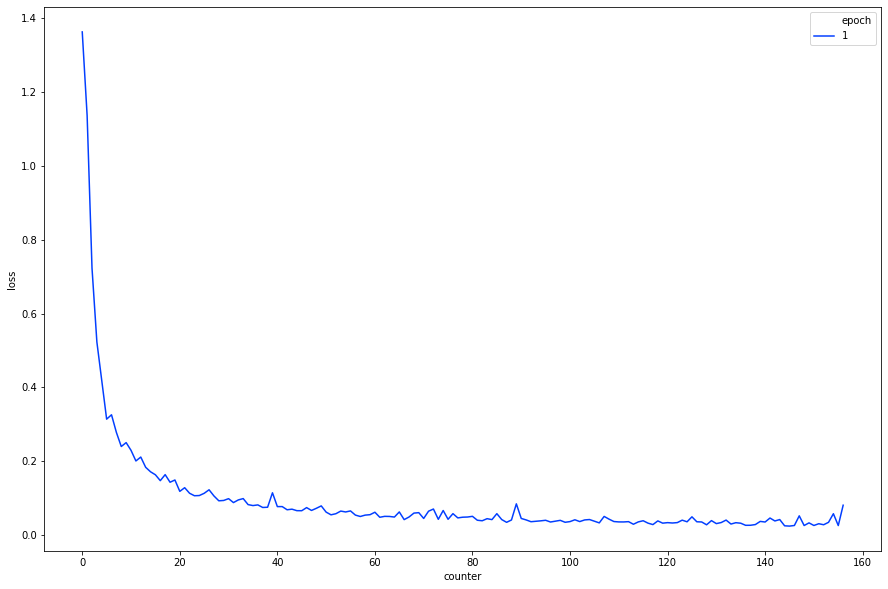

In [14]:
plt.figure(figsize=(15,10))
sns.lineplot(data=loss_df,x="counter",y="loss",hue="epoch",palette=sns.color_palette("bright",n_colors=len(loss_df.epoch.unique())))

In [15]:
imgs = ops[0][-1][1].reshape(-1,3,32,32).numpy()

In [16]:
imgs = imgs.transpose(0,2,3,1)

In [17]:
pred = ops[0][-1][2].reshape(-1,3,32,32).detach().numpy()

In [18]:
pred = pred.transpose(0,2,3,1)

In [19]:
index = 2

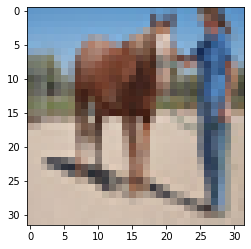

In [20]:
plt.imshow(imgs[index])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


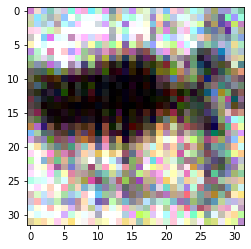

In [21]:
plt.imshow(pred[index])

In [23]:
n = Net(num_classes=10,
        encoder_model=m,
        sample_dataset=sample_ds,
        train_dataset=train_ds,
        num_epochs=20,
        learning_rate=1e-3,
        seed=42,
        use_graph=True)

2021-01-19 20:03:43.719 | INFO     | src.cifar_graph_classifier:__init__:51 - Using cpu
2021-01-19 20:03:43.722 | INFO     | src.cifar_graph_classifier:__init__:57 - Computing the embedding for the train dataset
100%|██████████| 469/469 [02:58<00:00,  2.62it/s]
2021-01-19 20:06:48.272 | INFO     | src.cifar_graph_classifier:__init__:63 - Will use graph to augment features
2021-01-19 20:06:48.287 | INFO     | src.cifar_graph_classifier:__init__:64 - Computing the embedding for the sample dataset
100%|██████████| 157/157 [01:39<00:00,  1.58it/s]


2021-01-19 20:08:33.091 | INFO     | src.cifar_graph_classifier:sanity_test:321 - label of current x = tensor([1])
2021-01-19 20:08:33.142 | INFO     | src.cifar_graph_classifier:test_forward_run:212 - x.shape = torch.Size([1, 1024])
2021-01-19 20:08:33.189 | INFO     | src.cifar_graph_classifier:test_forward_run:213 - x[:,:10] = tensor([[-1.1279, -1.9477,  1.4446, -0.5846, -0.8652,  1.4002, -0.2830,  0.3275,
         -0.7220,  0.3085]])
2021-01-19 20:08:33.189 | INFO     | src.cifar_graph_classifier:test_forward_run:214 - sample_xs.shape = torch.Size([2048, 1024])
2021-01-19 20:08:33.194 | INFO     | src.cifar_graph_classifier:test_forward_run:215 - sample_xs[:5,:10] = tensor([[-1.1961e+00, -1.7569e+00,  1.2420e+00, -4.9533e-01, -6.9235e-01,
          9.5236e-03,  3.6766e-01,  1.1184e+00,  1.7918e-01,  3.5302e-02],
        [ 1.9228e+00,  1.3026e+00, -7.1714e-01,  4.4068e-02,  5.5715e-01,
         -8.0637e-01,  2.6329e+00, -3.8026e-02,  1.3038e+00, -1.6449e+00],
        [-2.3183e+00, -

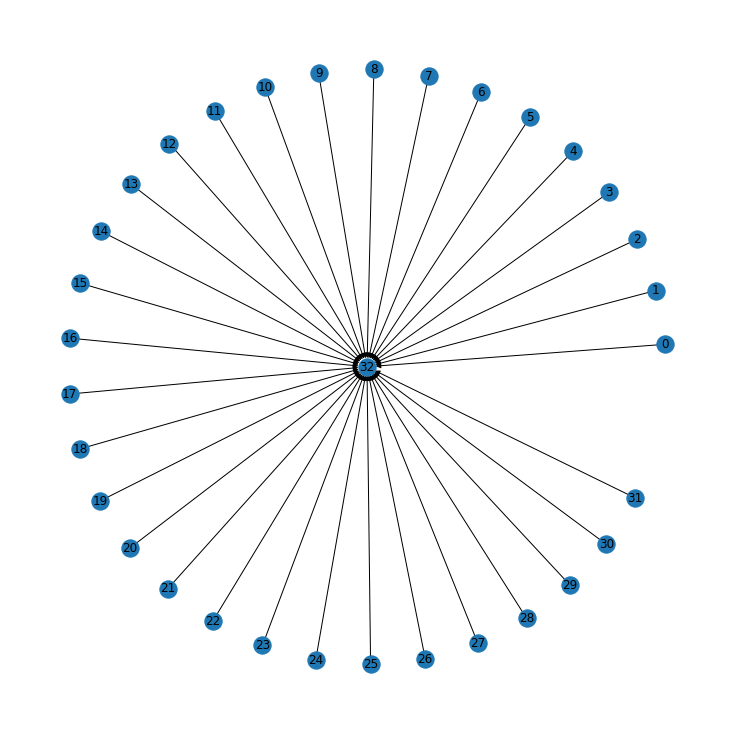

In [24]:
n.sanity_test()

In [26]:
loss = n.train()

In [ ]:
all_losses = []
index = 0
for i,x in enumerate(loss):
    for j,y in enumerate(x):
        all_losses.append({"counter":index,"epoch":i+1,"iteration":j+1,"loss":y})
        index+=1

In [ ]:
loss_df = pd.DataFrame(all_losses)

# w/o graph

<AxesSubplot:xlabel='counter', ylabel='loss'>

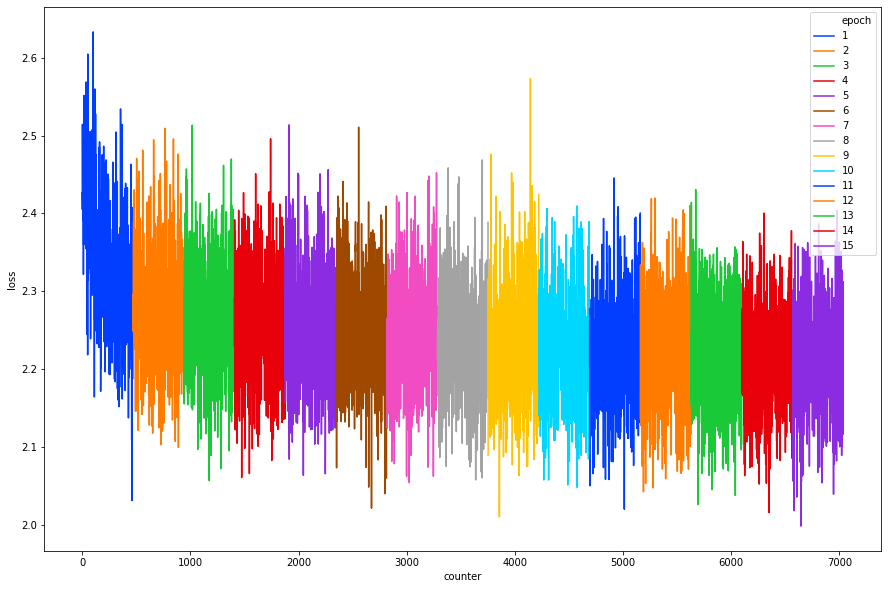

In [28]:
plt.figure(figsize=(15,10))
sns.lineplot(data=loss_df,x="counter",y="loss",hue="epoch",palette=sns.color_palette("bright",n_colors=len(loss_df.epoch.unique())))

# w graph

In [ ]:
plt.figure(figsize=(15,10))
sns.lineplot(data=loss_df,x="counter",y="loss",hue="epoch",palette=sns.color_palette("bright",n_colors=len(loss_df.epoch.unique())))

In [ ]:
clf_test_loader = n.get_encoding(sample_ds, 64)

In [ ]:
from tqdm import tqdm
import torch

In [ ]:
res = []
for data in tqdm(clf_test_loader):
    img, label = data
    recon = n.forward(img,is_train=False)
    _, preds = torch.max(recon, 1)
    bool_tensor = preds == label
    res.append(torch.stack([label,bool_tensor,preds],dim=1))

In [ ]:
all_res = torch.cat(res,dim=0)

In [ ]:
import numpy as np

In [ ]:
df_test_res = pd.DataFrame(all_res.numpy(),columns=["class","res","pred_class"])

# w graph

In [ ]:
df_test_res.groupby("res").count()/df_test_res.shape[0]

In [ ]:
confusion_matrix = pd.crosstab(df_test_res['class'], df_test_res['pred_class'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix